## Gaussian Graph Evolution

In [38]:
push!(LOAD_PATH, pwd())
using LightGraphs, IndirectRec, GraphConnectivityTheory,GraphCreation
using PyCall, PyPlot, Distributions
using GraphPlot, CliquePercolation
plt[:rc]("text",usetex=true)

### Functions for Gaussian Graphs

In [9]:
## FUNCTIONS TO CREATE A GAUSSIAN GRAPH
function getGaussianConstant(n,s,k)
    return ((pi/k)*(n/(s*s)))
end

function normal_distance(locx,locy,i,j)
    dx = abs(locx[i]-locx[j])
    dy = abs(locy[i]-locy[j])
    return sqrt(dx^2+dy^2)
end

function periodic_distance(locx,locy,i,j,length)
    dx = periodic_dist_one_dim(locx[i],locx[j],length)
    dy = periodic_dist_one_dim(locy[i],locy[j],length)
    return sqrt(dx^2 + dy^2)
end

function periodic_dist_one_dim(x1,x2,length)
    d = abs(x1-x2)
    return min(d,length-d)
end

function checkEdge!(g,i,j,a,locx,locy,length)
    d = periodic_distance(locx,locy,i,j,length)
    gaussianProbability = e^(-a*d^2)
    r = rand()
    if (r<gaussianProbability)
            add_edge!(g,i,j)
            return true
            #println("d=($d),  probability=$gaussianProbability, r = $r   Edge added")
    end
    return false
end   

function generate_gaussian_graph(N,k,locx=nothing,locy=nothing)
    GRAPH_LOCATION_SIZE = 1
    if locx == nothing || locy == nothing
        locx = rand(N)*GRAPH_LOCATION_SIZE;
        locy = rand(N)*GRAPH_LOCATION_SIZE;
    end

    g = Graph(N)
    alpha = getGaussianConstant(N,GRAPH_LOCATION_SIZE,k)
    println("length scale: $(1/sqrt(alpha))")
    for i in LightGraphs.vertices(g)
        for j in LightGraphs.vertices(g)
            if j > i
                checkEdge!(g,i,j,alpha,locx,locy,GRAPH_LOCATION_SIZE)
            end
        end
    end
    k_meas = mean(degree(g))
    c_meas = mean(local_clustering_coefficient(g))
    println("degree = $(k_meas), clustering = $(c_meas)")
    return g,locx,locy,alpha,GRAPH_LOCATION_SIZE
end

function plot_periodic_graph(h,locx,locy,length)
    # DO NOT MODIFY ORIGINAL GRAPH
    g = copy(h)
    for edge in LightGraphs.edges(h)
        node1,node2 = edge[1],edge[2]
        if (normal_distance(locx,locy,node1,node2)>periodic_distance(locx,locy,node1,node2,length))
            rem_edge!(g,Pair(node2,node1))
        end
    end
    gplot(g,locx,locy)
end

plot_periodic_graph (generic function with 1 method)

##  Simulation selection functions

In [20]:

# INTERACTION MATRIX
# int_m[i,j] = 2 if i defects with j and int_m[i,j] = 1 if i cooperates

# use an interaction matrix to remove Defecting edgs
function removeDefectingEdges!(g,interaction)
    # 2: DEFECT
    # 1: COOPERATE
    ni = length(vertices(g))
    for i in 1:ni
        for j in 1:ni
            if interaction[i,j] == 2
                # Atleast one defects, so remove this edge
                rem_edge!(g,Pair(i=>j))
            end
        end
    end   
    return g
end


# USE the interaction matrix to calculate payoff
function get_payoff_list_from_interaction_matrix(g,b_c_ratio,intm)
    nv = length(vertices(g))
    payoffm = []
    for i =1:nv
        # Count all the interactions for a node i
        p = 0
        for j=1:nv
            ai = intm[i,j]
            aj = intm[j,i]
            if (ai==1)&&(aj==1)
                p += b_c_ratio-1   # payoff cor cooperation
            elseif (ai==1)&&(aj==2)
                p += -1            # if i cooperates but j defects
            elseif (ai==2)&&(aj==1)  
                p += b_c_ratio    # if i defects and j cooperates
            else
                p += 0           # nothing happens, or they don't interact    
            end
        end
        push!(payoffm,p)        # push the sum
    end
    return payoffm
end


# SELECTION FUNCTIONS
# CRUX OF THE SIMULATION
function selection_simulated(g,p,b_c_ratio,num_trials=10)
    h = copy(g)   # create a new copy of the graph which gets edited
    removed_edges=[]
    n_v = length(vertices(g))
    num_edges = ne(h)  # number of edges in this graph. For bookkepping purposes
    interaction_matrix = zeros(Int64,(n_v,n_v))  # to record interactions
    for v in vertices(g)
        ns = neighbors(g,v)
        k = length(ns) - 1  # -1 because in LightGraphs convention, a node i is automatically 
                            #  a neighbor of the same node i
                            # the degree of a singleton is thus always one
        for w in ns 
            P_neighbor_known = get_p_known_from_neighbor_to_other_neighbor(g,p,v,w,num_trials)
            if  b_c_ratio < (1-DELTA)/((1/(k-1))*((P_neighbor_known*(k-1)+1)))
                # this means that the one of the node has already decided to defect
                interaction_matrix[v,w] = 2
            else
                # otherwise cooperate
                interaction_matrix[v,w] = 1
            end
        end
    end
    # Use the interaction matrix to remove defecting edges
    h = removeDefectingEdges!(h,interaction_matrix)
    num_edges_after = ne(h)  # final number of edges. For bookkeeping puposes
    num_edges_removed = num_edges - num_edges_after  # changes in the number of edges
    print(", $(num_edges_removed)" )
    return h,num_edges_removed,removed_edges,interaction_matrix
end






function selection_theoretical(g,p)
    #### Almost identical to selection_simulated 
    
    h = copy(g)   # create a new copy of the graph which gets edited
    removed_edges=[]
    n_v = length(vertices(g))
    num_edges = ne(h)  # number of edges in this graph. For bookkepping purposes
    interaction_matrix = zeros(Int64,(n_v,n_v))  # to record interactions
    for v in vertices(g)
        ns = neighbors(g,v)
        k = length(ns) - 1  # -1 because in LightGraphs convention, a node i is a neighbor of node i
                        # the degree of a singleton is thus always one
        for w in ns 
           #####
            n = get_num_mutual_neighbors(g,Pair(v,w))
            k = degree(g,v)-1   
            c = local_clustering_coefficient(g,v)
            P_neighbor_known = get_p_known_clique_neighbor_to_neighbor_theory(k,c,n,p)
            if  b_c_ratio < (1-DELTA)/((1/(k-1))*((P_neighbor_known*(k-1)+1)))
            ##### 
                # this means that the one of the node has already decided to defect               
                interaction_matrix[v,w] = 2
            else
                interaction_matrix[v,w] = 1
            end
        end
    end
    h = removeDefectingEdges!(h,interaction_matrix)
    num_edges_after = ne(h)  # final number of edges. For bookkeeping puposes
    num_edges_removed = num_edges - num_edges_after  # changes in the number of edges
    print(", $(num_edges_removed)" )
    return h,num_edges_removed,removed_edges,interaction_matrix
end



selection_theoretical (generic function with 1 method)

In [11]:



# HELPER FUNCTIONS

# To prevent certain kinds of edges.
# 1. Self-edge
# 2. edges that alreay exist
# Maybe unncessary

function valid_edge(g,e)
    if e[1] == e[2] return false end
    if has_edge(g,e) return false end
    return true
end

function add_random_edges(g,num_edges)
    added = 0
    vs = vertices(g)
    while added < numedges
        v1 = rand(vs)
        v2 = rand(vs)
        e = Pair(v1,v2)
        add_edge!(g,e)
        added += 1
    end
end

function add_random_gaussian_edges(g,num_edges,lx,ly,alpha,length)
    initEdge = ne(g) # initial number of edges
    vs = vertices(g)
    while ne(g) < initEdge+num_edges
        v1 = rand(vs)
        v2 = rand(vs)
        checkEdge!(g,v1,v2,alpha,lx,ly,length)
    end
end    


function get_cs_ks_ns(g)            
    cs = local_clustering_coefficient(g)
    ks = degree(g)
    ns = cs.*(ks-1)
    return cs,ks,ns
end

get_cs_ks_ns (generic function with 1 method)

# RUN THE SIMULATION HERE

In [12]:
G,LOCX,LOCY,ALPHA,LENGTH = generate_gaussian_graph(400,15);

length scale: 0.1092548430592079
degree = 15.19, clustering = 0.3448814666486577


In [13]:
# Set a global discounting rate here
DELTA = 0.2;
p = 0.3;
b_c_ratio = 1.5;
num_iters = 20;

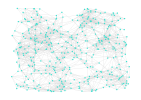

In [14]:
plot_periodic_graph(G,LOCX,LOCY,LENGTH)

In [21]:
## Non-theory simulation

g2 = copy(G) # Copy for editing
g_copies = [] # copies of graph for analysis
interaction_list = []
num_trials = 50
print(ne(g2))
print(" --- \n")
for i = 1:num_iters
    g_old = copy(g2)
    push!(g_copies,copy(g2))  # Push copies of g2
    g2,num_removed,edges_removed,interaction_matrix = selection_simulated(g2,p,b_c_ratio,num_trials)
    push!(interaction_list,interaction_matrix)
    if (i!=num_iters)
        add_random_gaussian_edges(g2,num_removed,LOCX,LOCY,ALPHA,LENGTH)
    end
end

3038 --- 
, 1854, 1461, 1128, 888, 718, 586, 457, 372, 308, 236, 171, 148, 106, 101, 69, 60, 52, 30, 19, 17

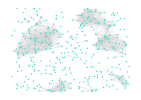

In [22]:
plot_periodic_graph(g2,LOCX,LOCY,LENGTH)

In [23]:
g2_th = copy(G) # Copy for editing
g_copies_th = [] # copies of graph for analysis
interaction_list_th = []
num_trials = 10
print(ne(g2_th))
print(" --- \n")
for i = 1:num_iters
    g_old_th = copy(g2_th)
    push!(g_copies_th,copy(g2_th))  # Push copies of g2
    g2_th,num_removed,edges_removed,interaction_matrix_th = selection_theoretical(g2_th,p)
    push!(interaction_list_th,interaction_matrix_th)
    if (i!=num_iters)
        add_random_gaussian_edges(g2_th,num_removed,LOCX,LOCY,ALPHA,LENGTH)
    end
end

3038 --- 
, 2037, 1558, 1225, 954, 734, 549, 388, 256, 205, 138, 106, 87, 64, 50, 43, 42, 17, 6, 2, 3

In [41]:
## get all the metrics from g_copies
degree_list = [degree(g_copies[i]) for i=1:length(g_copies)]
clustering_list = [local_clustering_coefficient(g_copies[i]) for i=1:length(g_copies)]
n_list = []
for i =1:length(g_copies)
    z = g_copies[i]
    push!(n_list,[])
    for v in vertices(z)
        push!(n_list[i],(degree(z,v)-2)*local_clustering_coefficient(z,v))
    end
end
pay_off = [get_payoff_list_from_interaction_matrix(G,b_c_ratio,interaction_list[i]) for i=1:length(interaction_list)]


degree_std = [std(x) for x in degree_list];
clustering_mean = [mean(x) for x in clustering_list];
payoff_mean = [mean(x) for x in pay_off];
n_mean = [mean(x) for x in n_list];



## get all the metrics from g_copies
degree_list_th = [degree(g_copies_th[i]) for i=1:length(g_copies_th)]
clustering_list_th = [local_clustering_coefficient(g_copies_th[i]) for i=1:length(g_copies_th)]
n_list_th = []
for i =1:length(g_copies_th)
    z = g_copies_th[i]
    push!(n_list_th,[])
    for v in vertices(z)
        push!(n_list_th[i],(degree(z,v)-2)*local_clustering_coefficient(z,v))
    end
end
pay_off_th = [get_payoff_list_from_interaction_matrix(G,b_c_ratio,interaction_list_th[i]) for i=1:length(interaction_list_th)]


degree_std_th = [std(x) for x in degree_list_th];
clustering_mean_th = [mean(x) for x in clustering_list_th];
payoff_mean_th = [mean(x) for x in pay_off_th];
n_mean_th = [mean(x) for x in n_list_th];


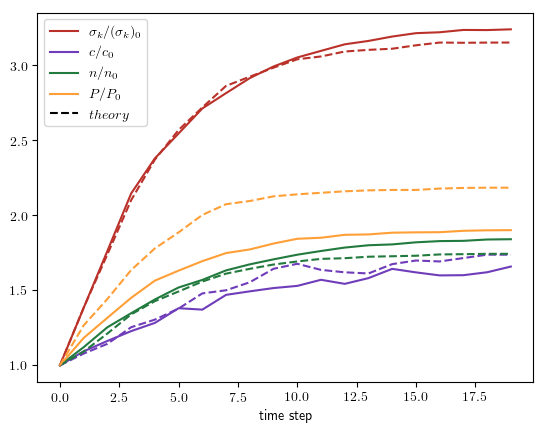

PyObject <matplotlib.legend.Legend object at 0x312c5d750>

In [40]:
plot(degree_std/degree_std[1],label=L" \sigma_k/(\sigma_k)_0",color="#BA312A")
plot(clustering_mean/clustering_mean[1],label=L"c / c_0",color="#6F3CBA")
plot(n_mean/n_mean[1],label=L"n/n_0",color="#227A3E")
plot(payoff_mean/payoff_mean[1],label=L"P/P_0",color="#FF9F37")

plot([],"--",label=L"theory",color="#000000")
plot(degree_std_th/degree_std_th[1],"--",color="#BA312A")
plot(clustering_mean_th/clustering_mean_th[1],"--",color="#6F3CBA")
plot(n_mean_th/n_mean_th[1],"--",color="#227A3E")
plot(payoff_mean_th/payoff_mean_th[1],"--",color="#FF9F37")

xlabel("time step")
legend(loc="best")

# Histograms 

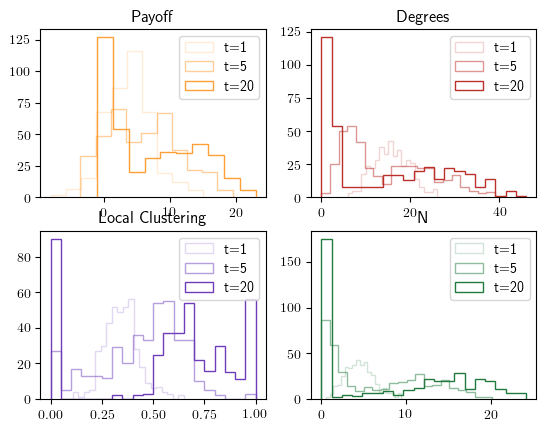

PyObject <matplotlib.legend.Legend object at 0x32fd10d90>

In [42]:
timesteps = [1,4,20]
subplot(2,2,3)
plt[:hist](clustering_list[1],alpha=0.2,bins=20,label="t=1",histtype="step",color="#6F3CBA")
plt[:hist](clustering_list[5],alpha=0.5,bins=20,label="t=5",histtype="step",color="#6F3CBA")
plt[:hist](clustering_list[20],alpha=1,bins=20,label="t=20",histtype="step",color="#6F3CBA")
title("Local Clustering")
legend()
subplot(2,2,2)
plt[:hist](degree_list[1],alpha=0.2,bins=20,label="t=1",histtype="step",color="#BA312A")
plt[:hist](degree_list[5],alpha=0.5,bins=20,label="t=5",histtype="step",color="#BA312A")
plt[:hist](degree_list[20],alpha=1,bins=20,label="t=20",histtype="step",color="#BA312A")
title("Degrees")
legend()
subplot(2,2,1)
plt[:hist](pay_off[1],alpha=0.2,bins=10,label="t=1",histtype="step",color="#FF9F37")
plt[:hist](pay_off[5],alpha=0.5,bins=10,label="t=5",histtype="step",color="#FF9F37")
plt[:hist](pay_off[20],alpha=1,bins=10,label="t=20",histtype="step",color="#FF9F37")
title("Payoff")
legend()
subplot(2,2,4)
plt[:hist](n_list[1],alpha=0.2,bins=20,label="t=1",histtype="step",color="#227A3E")
plt[:hist](n_list[5],alpha=0.5,bins=20,label="t=5",histtype="step",color="#227A3E")
plt[:hist](n_list[20],alpha=1,bins=20,label="t=20",histtype="step",color="#227A3E")
title("N")
legend()

### Get difference between simulated and theory


In [36]:
function theory_vs_simulation(g,p)
    sim=[]
    th=[]
    for v in vertices(g)
        print(v)
        print(", ")
        ns = neighbors(g,v) # For each neighbor.
        k = length(ns)
        if v in ns
            k = k - 1
        end # total cost depends on the number of neighborr
        cs = local_clustering_coefficient(g)
        for w in ns 
            if v != w
                n = get_num_mutual_neighbors(g,Pair(v,w))
                k = degree(g,v)-1
                c = cs[v]
                #push!(th,Float64(GraphConnectivityTheory.get_Tn_memoized(BigInt(k),BigFloat(p*c))))
                #push!(th,Float64(get_p_known_clique_theory(k-1,c*(k-1)/n,n/(k-1)*p)))
                push!(th,Float64(get_p_known_clique_neighbor_to_neighbor_theory(k,c,n,p)))
                push!(sim,Float64(get_p_known_from_neighbor_to_other_neighbor(g,p,v,w,100)))
            end
        end
    end
    return sim,th
end




theory_vs_simulation (generic function with 1 method)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

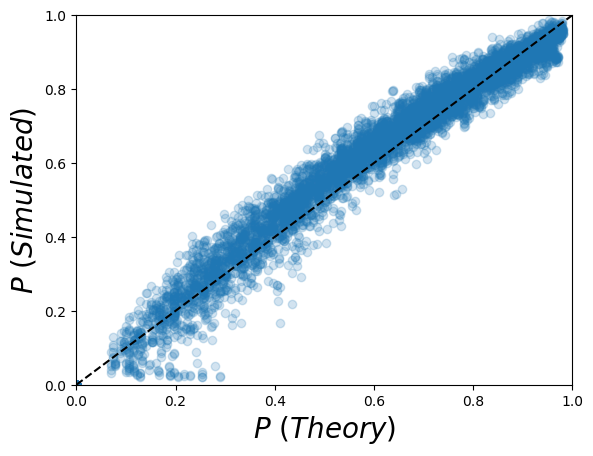

398, 399, 400, 

PyObject <matplotlib.text.Text object at 0x32f086190>

In [37]:
sim_list,th_list = theory_vs_simulation(G,0.4);
scatter(th_list,sim_list,alpha=0.2)
xx = 0:0.1:1
plot(xx,xx,"--k")
xlim([0,1])
ylim([0,1])
xlabel(latexstring("P \\ (Theory)"),size=20)
ylabel(latexstring("P \\ (Simulated)"),size=20)